In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05')[0])

(62.0, 69.57142857142857, 74.0)


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
year_data = calc_temps('2016-08-01', '2017-08-01')[0]
year_df = pd.DataFrame({'Min':[year_data[0]], 'Avg':[round(year_data[1], 2)], 'Max':[year_data[2]]})
year_df

,Min,Avg,Max
0,58.0,74.64,87.0


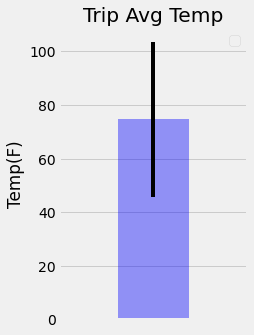

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
year_df.plot.bar(y='Avg', yerr=year_df['Max']-year_df['Min'], width=0.3, figsize=(3,5), \
                 capsize=0, ylabel='Temp(F)', color='b', alpha=0.4, title='Trip Avg Temp', xticks=())

plt.legend('')
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_prcp = session.query(Measurement.station, func.sum(Measurement.prcp).label('total prcp'), \
                  Station.latitude, Station.longitude, Station.elevation). \
                   join(Station, Station.station == Measurement.station). \
                   group_by('station').order_by(desc('total prcp')).all()
station_prcp

[('USC00516128', 1068.0899999999956, 21.3331, -157.8025, 152.4),
 ('USC00519281', 588.6399999999976, 21.45167, -157.84888999999998, 32.9),
 ('USC00513117', 382.61999999999847, 21.4234, -157.8015, 14.6),
 ('USC00519523', 295.67999999999944, 21.33556, -157.71139, 19.5),
 ('USC00514830', 234.49000000000026, 21.5213, -157.8374, 7.0),
 ('USC00519397', 131.62000000000063, 21.2716, -157.8168, 3.0),
 ('USC00511918', 92.68000000000006, 21.3152, -157.9992, 0.9),
 ('USC00518838', 70.87000000000005, 21.4992, -158.0111, 306.6),
 ('USC00517948', 43.44000000000002, 21.3934, -157.9751, 11.9)]

### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
d_range = pd.date_range(start=start_date,end=end_date)

# Strip off the year and save a list of strings in the format %m-%d
date_list = [dt.date(d_range[n]).strftime('%m-%d') for n in range(0,len(d_range))]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normal = [list(daily_normals(date)[0]) for date in date_list]


In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normal, index=date_list, columns=['Min','Avg','Max'])
df.index.name = 'date'
df

,Min,Avg,Max
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


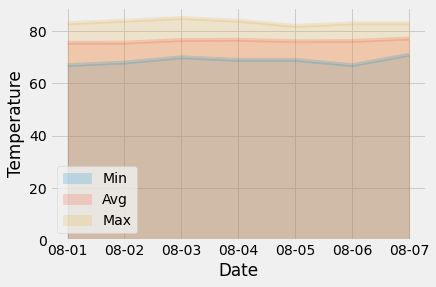

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False, alpha=0.2, ylabel='Temperature', xlabel='Date').legend(loc='lower left')
plt.show()

## Close Session

In [17]:
session.close()